In [389]:
import os
#set your environment variable for SSL certificate
certi_path = r"C:\Users\bertr\AppData\Local\Programs\Python\Python39\Lib\site-packages\pip\_vendor\certifi\cacert.pem"
os.environ['REQUESTS_CA_BUNDLE'] = certi_path
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import requests
import random
import time
import json
import pandas as pd
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver


In [390]:
def initialize_driver(headers_list, proxy_list):
    options = Options()
    #select a random user-agent from the list
    user_agent = random.choice(headers_list)["User-Agent"]
    options.add_argument(f"user-agent={user_agent}")
    
    #select a random proxy from the list
    proxy = random.choice(proxy_list)
    if proxy:
        options.add_argument(f"--proxy-server={proxy}")
    
    #add some common options
    options.add_argument("--headless")
    options.add_argument("--disable-extensions")
    options.add_argument("--ignore-certificate-errors")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    chrome_prefs = {}
    options.experimental_options["prefs"] = chrome_prefs
    chrome_prefs["profile.default_content_settings"] = {"images": 2}
    
    #initialize Chrome WebDriver with the specified options
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    #set implicit wait of 10sec
    driver.implicitly_wait(10)

    return driver

In [391]:
def MainPage(driver, url):
    driver.get(url)
    time.sleep(3)

In [392]:
def nbHisytoryByPage(driver):
    try:
        liste_histoires = driver.find_element(By.ID, "liste_histoires")
        search_results = driver.find_elements(By.TAG_NAME, "article")
        search_results_count = len(search_results)
        return search_results_count

    except Exception as e:
        print("An error occurred in nbHisytoryByPage:", str(e))
        return 0  # Or handle the exception as needed

In [393]:
def nbHisytoryTot(driver):
    try:
        search_results = driver.find_element(By.CSS_SELECTOR, 'div[class="row align-items-center gy-2 mb-4 pb-1 pb-sm-2 pb-lg-3"]')
        text_nb_hostory_tot = search_results.find_element(By.CSS_SELECTOR, 'h2[class="mb-lg-0"]').text.split('(')[1].split(')')[0]
        return int(text_nb_hostory_tot)

    except Exception as e:
        print("An error occurred in nbHisytoryTot:", str(e))
        return 0  # Or handle the exception as needed

In [394]:
def Click(driver, pos):
    '''Click on the link'''
    print(pos)
    print(len(driver.find_elements(By.CSS_SELECTOR, 'a[class="btn btn-sm btn-primary mb-1"]')))
    try:
        element = driver.find_elements(By.CSS_SELECTOR, 'a[class="btn btn-sm btn-primary mb-1"]')[pos]
        element.click()
        return 1

    except Exception as e:
        print("An error occurred in Click:", str(e))
        return 0

In [395]:
def ClickMoreHistory(driver):
    '''Click on the link'''
    try:
        element = driver.find_element(By.ID, "loadmorebtn")
        element.click()
        return 1

    except Exception as e:
        print("An error occurred in ClickMoreHistory:", str(e))
        return 0

In [396]:
def GetDatas(driver, story):
    time.sleep(3)
    try:
        age = driver.find_elements(By.CSS_SELECTOR, 'span[class="badge border border-light text-light fs-sm mb-1"]')[1].text
        title = driver.find_element(By.CSS_SELECTOR, 'h1[class="display-2 mb-4"]').text
        history = driver.find_element(By.CSS_SELECTOR, 'div[class="col-lg-9 col-xl-8"]').find_element(By.CSS_SELECTOR, 'div[class="fs-lg"]').get_attribute("outerHTML")
        lien_type_history = driver.find_element(By.CSS_SELECTOR, 'ol[class="pt-lg-3 pb-lg-4 pb-2 breadcrumb"]').find_elements(By.TAG_NAME, 'li')
        category = lien_type_history[3].find_element(By.TAG_NAME, 'a').text
        genre = lien_type_history[4].find_element(By.TAG_NAME, 'a').text

        # Récupération des questions et des réponses
        question_histoire = []
        try:
            accordion_question = driver.find_element(By.ID, "collapseOne")
            all_questions = accordion_question.find_elements(By.CSS_SELECTOR, 'h3[class="lead"]')
            for i in range(0, len(all_questions)):
                div_responses = accordion_question.find_elements(By.CSS_SELECTOR, 'div[class="card mb-4"]')[i]
                all_responses = div_responses.find_elements(By.CSS_SELECTOR, 'label[class="form-check-label"]')
                correction = driver.find_elements(By.CLASS_NAME, 'text-success')[i]
                tab_response = []
                for a in range(0, len(all_responses)):
                    tab_response.append(all_responses[a].get_attribute("textContent"))
                question_histoire.append({
                    "question" + str(i+1): {
                        "enonce":  accordion_question.find_elements(By.CSS_SELECTOR, 'h3[class="lead"]')[i].get_attribute("textContent"),
                        "responses": tab_response,
                        "correction": correction.get_attribute("id").split('_')[2]
                    }
                })
        except NoSuchElementException:
            print("Element collapseOne n'existe pas. Le quiz sera vide.")

        # Récupération du glossaire
        dictionnaire_glossaire = {}
        try:
            accordion_glossaire = driver.find_element(By.ID, "collapseTwo").find_element(By.TAG_NAME, 'dl')
            mots = accordion_glossaire.find_elements(By.TAG_NAME, 'dt')
            defs = accordion_glossaire.find_elements(By.TAG_NAME, 'dd')
            for i in range(0, len(mots)):
                dictionnaire_glossaire[mots[i].get_attribute("textContent")] = defs[i].get_attribute("textContent")
        except NoSuchElementException:
            print("Element collapseTwo n'existe pas. Le glossaire sera vide.")

        current_story = [age, title, history, category, genre, question_histoire, dictionnaire_glossaire]
        story.append(current_story)

        # Écriture dans le fichier
        with open('history.txt', 'a') as f:
            f.write(str(current_story))
            print(f'Écriture du travail : {driver.current_url}')
            f.write('\n')

        return 1

    except Exception as e:
        print(f"Erreur lors de l'analyse HTML : {e}")

In [397]:
driver = initialize_driver([
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.9",
        "Host": "httpbin.org",
        "Sec-Ch-Ua": "\"Chromium\";v=\"92\", \" Not A;Brand\";v=\"99\", \"Google Chrome\";v=\"92\"",
        "Sec-Ch-Ua-Mobile": "?0",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.5",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:90.0) Gecko/20100101 Firefox/90.0"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.5",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/604.1"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-GB,en;q=0.5",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:54.0) Gecko/20100101 Firefox/54.0"
    },
    {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.9",
        "Host": "httpbin.org",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.2 Safari/605.1.15"
    }
], [False])

In [398]:
MainPage(driver, r"https://www.meshistoiresdusoir.fr/g/histoires-fantastiques/")

In [399]:
nbHisytoryTotVar = nbHisytoryTot(driver)

In [400]:
nbHisytoryByPageVar = nbHisytoryByPage(driver)

In [401]:
nb_page = nbHisytoryTotVar // nbHisytoryByPageVar
if nbHisytoryTotVar % nbHisytoryByPageVar != 0:
    nb_page = nb_page + 1

In [402]:
story = []
nb_history_page_init = nbHisytoryByPage(driver)
counter = 0
for a in range(0, nb_page):
    for i in range(0, 12):
        if counter != nbHisytoryTotVar:
            for t in range(0, a):
                time.sleep(2)
                ClickMoreHistory(driver)
                time.sleep(2)
            Click(driver, counter)
            GetDatas(driver, story)
            counter = counter + 1
            driver.back()
        else:
            break

0
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/elian-le-jeune-sorcier-de-lenchantement/
1
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/les-aventures-delara-sorciere-de-lumeria/
2
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/eliane-gardienne-de-la-foret-enchantee/
3
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/les-secrets-de-mythoria/
4
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/la-quete-des-dragons-chocolates/
5
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/la-pierre-sacree-la-quete-de-lelue/
6
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/lelue-des-etoiles/
7
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/orion-le-voyageur-des-etoiles/
8
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/la-legende-delara-guerriere-du-royaume/
9
12
Écriture du travail : https://www.meshistoiresdusoir.fr/h/les-chroniques-demeric-la-quete-des-artefacts-magiques/
10
12
É

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(story)
df.columns = ["Age", "Titre", "Histoire", "Category", "Genre", "Questions", "Glossaire"]
df = df.sort_values(by=['Age', 'Category', 'Genre'], ascending=[False, False, False])
df

,Age,Titre,Histoire,Category,Genre,Questions,Glossaire
7,7/8 ans,"Orion, le Voyageur des Étoiles","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Hommes,[{'question1': {'enonce': 'Quel est le nom du ...,"{'Distorsion': 'Action de déformer, de tordre ..."
6,7/8 ans,L'Élue des Étoiles,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Femmes,[{'question1': {'enonce': 'Quel est le nom de ...,"{'éclatante': 'Qui brille intensément, qui est..."
0,7/8 ans,"Élian, le Jeune Sorcier de l'Enchantement","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Histoires fantastiques de sorcellerie,Sorciers,[{'question1': {'enonce': 'Quel don particulie...,{'Pouvoirs': 'Capacités magiques ou surnaturel...
1,7/8 ans,"Les Aventures d'Elara, Sorcière de Luméria","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Histoires fantastiques de sorcellerie,Apprenties sorcières,[{'question1': {'enonce': 'Quel âge avait Elar...,{'Incantation': 'Formule magique récitée pour ...
11,7/8 ans,Rugo le Tyrannosaure : Le Héros de la Vallée,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Histoires de dinosaures,Tyrannosaures Rex,[{'question1': {'enonce': 'Quel est le nom du ...,{'Majestueusement': 'D'une manière impressionn...
9,7/8 ans,Les Chroniques d'Émeric : La Quête des Artefac...,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Heroic Fantasy (Médiéval-Fantastique),Hommes,[{'question1': {'enonce': 'Quel est le nom du ...,"{'Firmier': 'Personne qui cultive la terre', '..."
8,7/8 ans,"La Légende d'Elara, Guerrière du Royaume","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Heroic Fantasy (Médiéval-Fantastique),Femmes,[{'question1': {'enonce': 'Quel était le nom d...,"{'Intrépide': 'Qui ne redoute pas le danger, c..."
4,7/8 ans,La Quête des Dragons Chocolatés,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy historique,Hommes,[{'question1': {'enonce': 'Quel est le métier ...,"{'Médiéval': 'Qui se rapporte au Moyen Âge, un..."
10,7/8 ans,Les Protecteurs de l'Ombre,"<div class=""fs-lg"">\n<p>Je vous présente mon h...",Fantasy historique,Hommes,[{'question1': {'enonce': 'Qui a enlevé la pri...,{'épreuves': 'Des difficultés ou des défis à s...
5,7/8 ans,La Pierre Sacrée : La Quête de l'Élue,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy historique,Femmes,[{'question1': {'enonce': 'Quel était le nom d...,{'Herboriste': 'Personne qui se spécialise dan...


<Axes: title={'center': "Nombre d'histoire par age"}, xlabel='Age', ylabel="Nombre d'histoire">

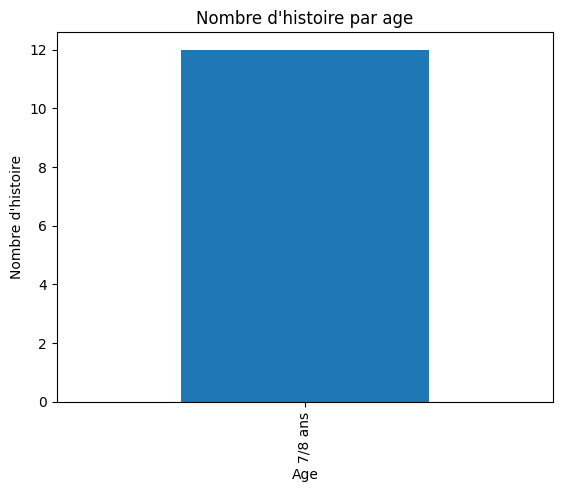

In [ ]:
age_story_count = df['Age'].value_counts().sort_index()
age_story_count.plot(kind='bar', xlabel='Age', ylabel='Nombre d\'histoire', title='Nombre d\'histoire par age')

<Axes: title={'center': "Nombre d'histoire par category"}, xlabel='Category', ylabel="Nombre d'histoire">

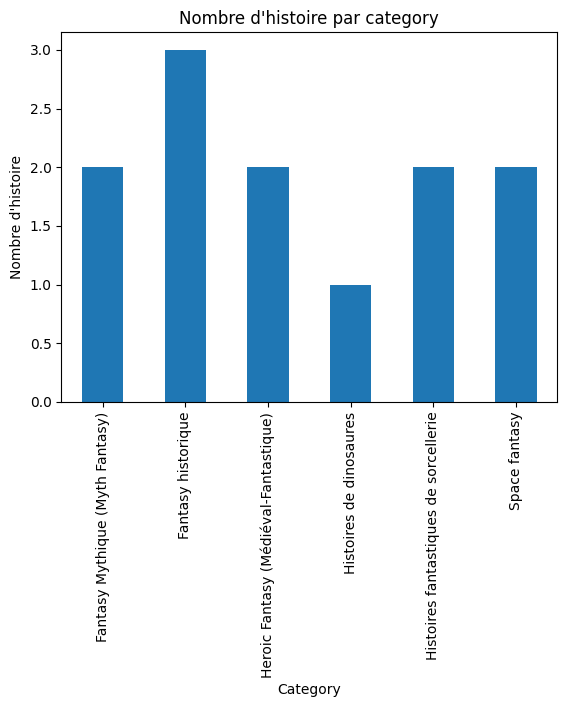

In [ ]:
category_story_count = df['Category'].value_counts().sort_index()
category_story_count.plot(kind='bar', xlabel='Category', ylabel='Nombre d\'histoire', title='Nombre d\'histoire par category')

<Axes: title={'center': "Nombre d'histoire par genre"}, xlabel='Genre', ylabel="Nombre d'histoire">

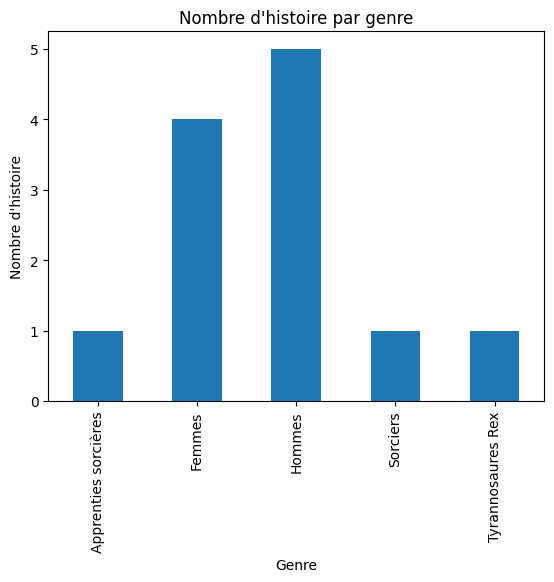

In [ ]:
genre_story_count = df['Genre'].value_counts().sort_index()
genre_story_count.plot(kind='bar', xlabel='Genre', ylabel='Nombre d\'histoire', title='Nombre d\'histoire par genre')

In [ ]:
!docker run --name postgres_story_db -d -p 5432:5432 -e POSTGRES_PASSWORD=story_pass postgres:alpine

6e1bb5c175b690de544ac096b7eff53cf6c17396279f724e9c76f7473357e5ee


In [ ]:
from sqlalchemy import create_engine

# Database credentials
user = 'postgres'
password = 'story_pass'
host = 'localhost'  # or the IP if your PostgreSQL server is running elsewhere
port = '5432'       # default port for PostgreSQL used by our docker above
db = 'postgres'

# Create the connection
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{db}')

In [ ]:
df['Glossaire'] = df['Glossaire'].apply(json.dumps)
df['Questions'] = df['Questions'].apply(json.dumps)

In [ ]:
df

,Age,Titre,Histoire,Category,Genre,Questions,Glossaire
7,7/8 ans,"Orion, le Voyageur des Étoiles","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Hommes,"[{""question1"": {""enonce"": ""Quel est le nom du ...","{""Distorsion"": ""Action de d\u00e9former, de to..."
6,7/8 ans,L'Élue des Étoiles,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Space fantasy,Femmes,"[{""question1"": {""enonce"": ""Quel est le nom de ...","{""\u00e9clatante"": ""Qui brille intens\u00e9men..."
0,7/8 ans,"Élian, le Jeune Sorcier de l'Enchantement","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Histoires fantastiques de sorcellerie,Sorciers,"[{""question1"": {""enonce"": ""Quel don particulie...","{""Pouvoirs"": ""Capacit\u00e9s magiques ou surna..."
1,7/8 ans,"Les Aventures d'Elara, Sorcière de Luméria","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Histoires fantastiques de sorcellerie,Apprenties sorcières,"[{""question1"": {""enonce"": ""Quel \u00e2ge avait...","{""Incantation"": ""Formule magique r\u00e9cit\u0..."
11,7/8 ans,Rugo le Tyrannosaure : Le Héros de la Vallée,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Histoires de dinosaures,Tyrannosaures Rex,"[{""question1"": {""enonce"": ""Quel est le nom du ...","{""Majestueusement"": ""D'une mani\u00e8re impres..."
9,7/8 ans,Les Chroniques d'Émeric : La Quête des Artefac...,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Heroic Fantasy (Médiéval-Fantastique),Hommes,"[{""question1"": {""enonce"": ""Quel est le nom du ...","{""Firmier"": ""Personne qui cultive la terre"", ""..."
8,7/8 ans,"La Légende d'Elara, Guerrière du Royaume","<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Heroic Fantasy (Médiéval-Fantastique),Femmes,"[{""question1"": {""enonce"": ""Quel \u00e9tait le ...","{""Intr\u00e9pide"": ""Qui ne redoute pas le dang..."
4,7/8 ans,La Quête des Dragons Chocolatés,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy historique,Hommes,"[{""question1"": {""enonce"": ""Quel est le m\u00e9...","{""M\u00e9di\u00e9val"": ""Qui se rapporte au Moy..."
10,7/8 ans,Les Protecteurs de l'Ombre,"<div class=""fs-lg"">\n<p>Je vous présente mon h...",Fantasy historique,Hommes,"[{""question1"": {""enonce"": ""Qui a enlev\u00e9 l...","{""\u00e9preuves"": ""Des difficult\u00e9s ou des..."
5,7/8 ans,La Pierre Sacrée : La Quête de l'Élue,"<div class=""fs-lg"">\n<h3 class=""bg-primary tex...",Fantasy historique,Femmes,"[{""question1"": {""enonce"": ""Quel \u00e9tait le ...","{""Herboriste"": ""Personne qui se sp\u00e9cialis..."


In [ ]:
time.sleep(10)

In [ ]:
df.to_sql('story_table', engine, if_exists='replace', index=False)

12

In [ ]:
import psycopg2

#connect to the PostgreSQL database
conn = psycopg2.connect(dbname='postgres', user=user, password=password, host=host, port=port)

#create a cursor object
cursor = conn.cursor()

#list all tables in the database
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table)

#check if job_table is created
if ('story_table',) in tables:
    print("\nTable 'story_table' exists.")
else:
    print("\nTable 'story_table' does not exist.")

#perform a verification query (e.g., selecting the first 5 rows)
query = "SELECT * FROM story_table LIMIT 5"
df = pd.read_sql(query, conn)
print("\nFirst 5 rows of 'story_table':")
print(df)

Tables in the database:
('story_table',)

Table 'story_table' exists.

First 5 rows of 'story_table':
       Age                                         Titre  \
0  7/8 ans                Orion, le Voyageur des Étoiles   
1  7/8 ans                            L'Élue des Étoiles   
2  7/8 ans     Élian, le Jeune Sorcier de l'Enchantement   
3  7/8 ans    Les Aventures d'Elara, Sorcière de Luméria   
4  7/8 ans  Rugo le Tyrannosaure : Le Héros de la Vallée   

                                            Histoire  \
0  <div class="fs-lg">\n<h3 class="bg-primary tex...   
1  <div class="fs-lg">\n<h3 class="bg-primary tex...   
2  <div class="fs-lg">\n<h3 class="bg-primary tex...   
3  <div class="fs-lg">\n<h3 class="bg-primary tex...   
4  <div class="fs-lg">\n<h3 class="bg-primary tex...   

                                Category                 Genre  \
0                          Space fantasy                Hommes   
1                          Space fantasy                Femmes   
2 

C:\Users\bertr\AppData\Local\Temp\ipykernel_13528\3596792087.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
!docker run -d --name mongo_story_db -p 27017:27017 mongo

646c8d9763fffc4c31e5b738539b97d192d010129ba0bde7db9c81ad12d2e64f


In [ ]:
from pymongo import MongoClient

#connect to the MongoDB server (default is localhost on port 27017)
client = MongoClient('localhost', 27017)

#access the database (create it if it doesn't exist)
db = client['story_database']

#access the collection (similar to a table in relational databases)
collection = db['story_collection']

In [ ]:
#convert DataFrame to dictionary format and insert into our MongoDB database
collection.insert_many(df.to_dict('records'))

InsertManyResult([ObjectId('66052c5e531934189587904c'), ObjectId('66052c5e531934189587904d'), ObjectId('66052c5e531934189587904e'), ObjectId('66052c5e531934189587904f'), ObjectId('66052c5e5319341895879050')], acknowledged=True)

In [ ]:
cursor = collection.find({"Age": "9 ans et plus"})
for document in cursor:
    print(document)

In [ ]:
driver.quit()